load and plot data
항상 순서는 

load data->
define model->
compile model->
fit model->
evaluate model->
tie it all together


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt

tf.set_random_seed(77)

#Min Max Normalization
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [2]:
# train Parameters
seq_length = 7
data_dim = 6
hidden_dim = 10
output_dim = 1
learning_rate = 0.01

# bid ask low high volume
xy = np.genfromtxt('../data/bitcoin_market.csv', delimiter=',', dtype=np.str)[:,[4,7,8,9,10,11]]
print(xy[0])

xy = xy[1:].astype(np.float)
xy = MinMaxScaler(xy[1:]) #normalize
x = xy[:]
y = xy[:,[0]]
print(x[:2])
print(y[:2])

['last' 'bid' 'ask' 'low' 'high' 'volume']
[[ 0.52493075  0.37053353  0.52463567  0.60770975  0.54615385  0.32157781]
 [ 0.59141274  0.41752325  0.59333796  0.60770975  0.52820513  0.32015694]]
[[ 0.52493075]
 [ 0.59141274]]


In [3]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next last price
    if i < 2 : print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[ 0.52493075  0.37053353  0.52463567  0.60770975  0.54615385  0.32157781]
 [ 0.59141274  0.41752325  0.59333796  0.60770975  0.52820513  0.32015694]
 [ 0.55817175  0.39402839  0.57321305  0.60770975  0.52820513  0.32937215]
 [ 0.60249307  0.39255996  0.59750173  0.60770975  0.52820513  0.33856945]
 [ 0.50069252  0.35340186  0.50104094  0.60770975  0.52820513  0.34429369]
 [ 0.51385042  0.35829662  0.50728661  0.60770975  0.52820513  0.35179124]
 [ 0.47368421  0.33431229  0.48507981  0.60770975  0.51623932  0.34650965]] -> [ 0.48268698]
[[ 0.59141274  0.41752325  0.59333796  0.60770975  0.52820513  0.32015694]
 [ 0.55817175  0.39402839  0.57321305  0.60770975  0.52820513  0.32937215]
 [ 0.60249307  0.39255996  0.59750173  0.60770975  0.52820513  0.33856945]
 [ 0.50069252  0.35340186  0.50104094  0.60770975  0.52820513  0.34429369]
 [ 0.51385042  0.35829662  0.50728661  0.60770975  0.52820513  0.35179124]
 [ 0.47368421  0.33431229  0.48507981  0.60770975  0.51623932  0.34650965]
 [ 0.48

In [4]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])

print(trainX[:2])
print(trainY[:2])


[[[ 0.52493075  0.37053353  0.52463567  0.60770975  0.54615385  0.32157781]
  [ 0.59141274  0.41752325  0.59333796  0.60770975  0.52820513  0.32015694]
  [ 0.55817175  0.39402839  0.57321305  0.60770975  0.52820513  0.32937215]
  [ 0.60249307  0.39255996  0.59750173  0.60770975  0.52820513  0.33856945]
  [ 0.50069252  0.35340186  0.50104094  0.60770975  0.52820513  0.34429369]
  [ 0.51385042  0.35829662  0.50728661  0.60770975  0.52820513  0.35179124]
  [ 0.47368421  0.33431229  0.48507981  0.60770975  0.51623932  0.34650965]]

 [[ 0.59141274  0.41752325  0.59333796  0.60770975  0.52820513  0.32015694]
  [ 0.55817175  0.39402839  0.57321305  0.60770975  0.52820513  0.32937215]
  [ 0.60249307  0.39255996  0.59750173  0.60770975  0.52820513  0.33856945]
  [ 0.50069252  0.35340186  0.50104094  0.60770975  0.52820513  0.34429369]
  [ 0.51385042  0.35829662  0.50728661  0.60770975  0.52820513  0.35179124]
  [ 0.47368421  0.33431229  0.48507981  0.60770975  0.51623932  0.34650965]
  [ 0.4826

In [5]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# outputs[:, -1] : all batch of data_dim of last seq_length
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

[step: 0] loss: 882.1521606445312
[step: 1] loss: 626.0106811523438
[step: 2] loss: 442.33563232421875
[step: 3] loss: 308.403076171875
[step: 4] loss: 209.56637573242188
[step: 5] loss: 136.43344116210938
[step: 6] loss: 83.13798522949219
[step: 7] loss: 45.854331970214844
[step: 8] loss: 21.82154083251953
[step: 9] loss: 8.7467679977417
[step: 10] loss: 4.444291591644287
[step: 11] loss: 6.609676837921143
[step: 12] loss: 12.712723731994629
[step: 13] loss: 20.12505340576172
[step: 14] loss: 26.582311630249023
[step: 15] loss: 30.68248748779297
[step: 16] loss: 32.0045051574707
[step: 17] loss: 30.86747932434082
[step: 18] loss: 27.973358154296875
[step: 19] loss: 24.10784149169922
[step: 20] loss: 19.95472526550293
[step: 21] loss: 16.01665687561035
[step: 22] loss: 12.606901168823242
[step: 23] loss: 9.878338813781738
[step: 24] loss: 7.865300178527832
[step: 25] loss: 6.523555755615234
[step: 26] loss: 5.762818813323975
[step: 27] loss: 5.470576763153076
[step: 28] loss: 5.5285983

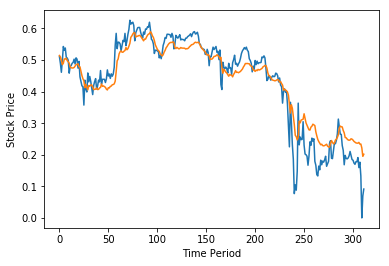

In [6]:

# train Parameters
iterations = 200

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))
#         print(sess.run(outputs[:, -1], feed_dict={X: trainX, Y: trainY}))
        
    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    
    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [ ]:
xy = MinMaxScaler(xy[1:]) #normalize

In [ ]:
xy

In [ ]:
x = xy[:]
y = xy[:,[0]]
print(x[:2])
print(y[:2])

In [ ]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next last price
    if i < 2 : print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

In [ ]:
dataX

In [ ]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])

print(trainX[:2])
print(trainY[:2])

In [ ]:
#input placeholders
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, 1])

#build a LSTM network